In [1]:
from enum import Enum
from functools import partial
import numpy as np
import queue
import seaborn as sns

### Definição das estruturas de dados

In [2]:
class PriorityQueue:
    
    def __init__(self, chave=lambda x: x): # Parametrizado com a função usada para comparação. Assim, a classe é mais versátil.
        self.heap = []
        self.chave = chave

    def menor(self):
        if len(self.heap) == 0:
            raise RuntimeError("Tentando ver o menor valor da fila de prioridade vazia")
            
        return self.heap[0]
    def empty(self):
        if len(self.heap) == 0:
            return True
        else:
            return False
        
    def pop(self):
        if len(self.heap) == 0:
            raise RuntimeError("Tentando extrair valor da fila de prioridade vazia")
            
        menor = self.heap[0]
        self.heap[0] = self.heap[-1]
        self.heap.pop()
        self.desce(0)

        # print("heap: ", self.heap) # debug

        return menor

    def add(self, valor):
        self.heap.append(valor)
        self.sobe(len(self.heap) - 1)
        
        # print("Heap:", self.heap) # debug
    
    def sobe(self, indice):
        if indice == 0: # Já está "no topo"
            return

        pai = (indice - 1) // 2
        if self.chave(self.heap[indice]) < self.chave(self.heap[pai]): # Se o novo elemento for maior que o pai
            tmp = self.heap[pai]
            self.heap[pai] = self.heap[indice]
            self.heap[indice] = tmp
            self.sobe(pai)

    def desce(self, indice):
        idx_filho_esq, idx_filho_dir = indice * 2 + 1, indice * 2 + 2

        if len(self.heap) <= idx_filho_esq:
            return
        if len(self.heap) == idx_filho_dir:
            filho_esq = self.heap[idx_filho_esq]
            filho_dir = None
        else:
            filho_esq, filho_dir = self.heap[idx_filho_esq], self.heap[idx_filho_dir]

        if filho_dir is None or self.chave(filho_esq) < self.chave(filho_dir):
            menor_filho = filho_esq
            idx_menor_filho = idx_filho_esq
        else:
            menor_filho = filho_dir
            idx_menor_filho = idx_filho_dir
        
        if self.chave(self.heap[indice]) > self.chave(menor_filho):    
            tmp = self.heap[idx_menor_filho]
            self.heap[idx_menor_filho] = self.heap[indice]
            self.heap[indice] = tmp
            self.desce(idx_menor_filho)
            

In [3]:
class Job:
    job_id = 0
    def __init__(self, tempo_chegada):
        self.tempo_chegada = tempo_chegada
        self.id = Job.job_id
        Job.job_id += 1

In [4]:
class TipoEvento(Enum):
    CHEGADA = 0
    SAIDA_S1 = 1
    SAIDA_S2 = 2
    SAIDA_S3 = 3

### Amostragens das VAs necessárias

#### Exponencial
Para amostrar essa VA, vamos utilizar o método da inversa da CDF. Dado que a pdf de $X \sim Exp(\lambda)$ é dada por
$$f(x) = \lambda e^{-\lambda x}$$

Podemos calcular a cdf $F(x)$ por:
$$F(x) = \int_{-\infty}^x \lambda e^{-\lambda t} dt = \int_0^x \lambda e^{-\lambda t} dt = $$
$$\left. -e^{-\lambda t} \right\rvert^x_0 = -e^{-\lambda x} - (- e^0) = $$
$$1 - e^{-\lambda x}$$

E para calcular $F^{-1}(x)$,
$$y = 1 - e^{-\lambda x}$$

Queremos encontrar $x$ em função de $y$,
$$y - 1 = -e^{-\lambda x}$$
$$1 - y = e^{-\lambda x}$$
$$ln(1 - y) = -\lambda x$$
$$-\frac{ln(1 - y)}{\lambda} = x$$
$$F^{-1}(x) = -\frac{ln(1 - x)}{\lambda}$$

#### Uniforme
Para essa VA $X \sim Unif(a, b)$, a pdf é dada por
$$f(x) = \frac{1}{b - a}$$

Calculando a cdf,
$$F(x) = \int_{-\infty}^x = \int_a^t \frac{1}{b - a} dt = $$
$$\left. \frac{t}{b - a}\right\rvert^x_a = \frac{x}{b - a} - \frac{a}{b - a} = \frac{x - a}{b - a}$$
$$F(x) = \frac{x - a}{b - a}$$

Calculando a inversa:
$$y = \frac{x - a}{b - a}$$
$$y(b - a) = x - a$$
$$x = y(b - a) + a$$
$$F^{-1}(x) = x(b - a) + a$$

In [5]:
class VAExponencial: # Para modelar o "Inter-Arrival Time" e os tamanhos dos jobs no terceiro cenário
    def __init__(self, Lambda):
        self.Lambda = Lambda

    def inversa_cdf(self, x):
        return -(np.log(1 - x)/self.Lambda)
    
    def amostrar(self):
        return self.inversa_cdf(np.random.rand())
        
class VAConstante: # Distribuição dos tamanhos dos jobs no primeiro cenário
    def __init__(self, c):
        self.param = c
    
    def amostrar(self):
        return self.param

class VAUniforme: # Distribuição dos tamanhos dos jobs no segundo cenário
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def inversa_cdf(self, x):
        return x * (self.b - self.a) + self.a
    
    def amostrar(self):
        return self.inversa_cdf(np.random.rand())

Média: 5.016197563769867 Correto, 1/lambda


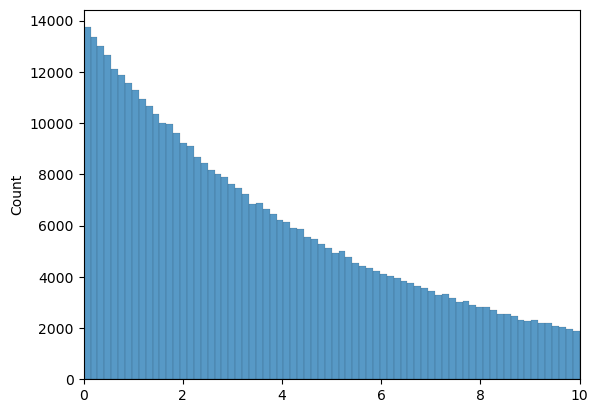

In [6]:
# Testando empiricamente

num_amostras = 500000
exp = VAExponencial(1/5)
lista = [exp.amostrar() for _ in range(num_amostras)]

histograma = sns.histplot(lista)
histograma.set_xlim(0, 10)

print('Média:', np.mean(lista), "Correto, 1/lambda")

<Axes: ylabel='Count'>

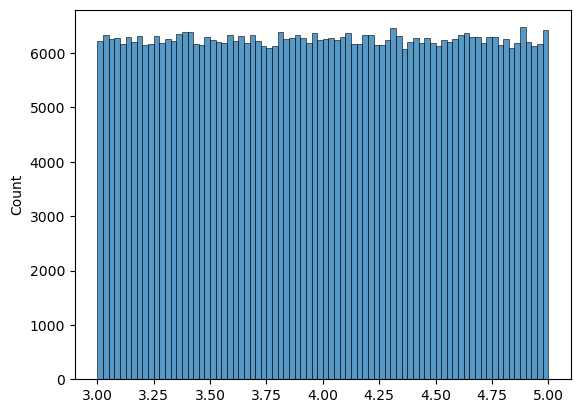

In [7]:
unif = VAUniforme(3, 5)
lista = [unif.amostrar() for i in range(num_amostras)]

histograma = sns.histplot(lista)
histograma

### Setup da Simulação

In [ ]:
vas_cenarios = [
    {
        's_1': VAConstante(0.4),
        's_2': VAConstante(0.6),
        's_3': VAConstante(0.95)
    },
    {
        's_1': VAUniforme(0.1, 0.7),
        's_2': VAUniforme(0.1, 1.1),
        's_3': VAUniforme(0.1, 1.8)
    }, 
    {
        's_1': VAExponencial(1/0.4),
        's_2': VAExponencial(1/0.6),
        's_3': VAExponencial(1/0.95)
    }]


num_jobs = 10000
num_jobs_warmup = 10000

for num_cenario, vas_cenario in enumerate(vas_cenarios):
    # Inicialização
    filas_servidores = [None, queue.Queue(), queue.Queue(), queue.Queue()]
    Job.job_id = 0
    ultima_chegada = 0
    exp = VAExponencial(2)
    eventos = PriorityQueue(chave=lambda x: x[1])

    # Todas as chegadas primeiro
    for _ in range(num_jobs_warmup + num_jobs):
        ultima_chegada += exp.amostrar()
        eventos.add((TipoEvento.CHEGADA, ultima_chegada))

    relogio = 0
    tempos_no_sistema = []
    while not eventos.empty():
        # print(f"{len(eventos.heap)} eventos na fila, relogio: {relogio}") # debug

        evento = eventos.pop()
        relogio = evento[1]
        match evento[0]:
            case TipoEvento.CHEGADA:
                # print("tratando chegada") # debug
                if filas_servidores[1].empty():
                    eventos.add((TipoEvento.SAIDA_S1, relogio + vas_cenario['s_1'].amostrar()))

                filas_servidores[1].put(Job(relogio))
                                
            case TipoEvento.SAIDA_S1:
                # print("tratando saida s1") # debug
                job_saindo = filas_servidores[1].get()
                
                if not filas_servidores[1].empty(): # Adiciona a próxima saída, se houver job na fila
                    eventos.add((TipoEvento.SAIDA_S1, relogio + vas_cenario['s_1'].amostrar()))
                    
                if np.random.rand() < 0.5:
                    if filas_servidores[2].empty():
                        eventos.add((TipoEvento.SAIDA_S2, relogio + vas_cenario['s_2'].amostrar()))
                    filas_servidores[2].put(job_saindo)
                    
                else:
                    if filas_servidores[3].empty():
                        eventos.add((TipoEvento.SAIDA_S3, relogio + vas_cenario['s_3'].amostrar()))
                    filas_servidores[3].put(job_saindo)
                    
            case TipoEvento.SAIDA_S2:
                # print("tratando saida s2") # debug
                job_saindo = filas_servidores[2].get()

                if not filas_servidores[2].empty():
                    eventos.add((TipoEvento.SAIDA_S2, relogio + vas_cenario['s_2'].amostrar()))
                
                if np.random.rand() < 0.2:
                    if filas_servidores[2].empty():
                        eventos.add((TipoEvento.SAIDA_S2, relogio + vas_cenario['s_2'].amostrar()))
                    filas_servidores[2].put(job_saindo)
                    
                elif job_saindo.id >= num_jobs_warmup:
                        tempos_no_sistema.append(relogio - job_saindo.tempo_chegada)

            case TipoEvento.SAIDA_S3:
                # print("tratando saida s3") # debug
                job_saindo = filas_servidores[3].get()

                if not filas_servidores[3].empty():
                    eventos.add((TipoEvento.SAIDA_S3, relogio + vas_cenario['s_3'].amostrar()))
                    
                if job_saindo.id >= num_jobs_warmup:
                    tempos_no_sistema.append(relogio - job_saindo.tempo_chegada)
                
    tempo_medio_no_sistema = np.mean(tempos_no_sistema)
    desvio_padrao_tempo_no_sistema = np.std(tempos_no_sistema)

    print(f"CENÁRIO {num_cenario + 1}") 
    print(f'Tempo médio no sistema: {tempo_medio_no_sistema}')
    print(f'Desvio padrão do tempo no sistema: {desvio_padrao_tempo_no_sistema}')
    print("")

CENÁRIO 1
Tempo médio no sistema: 6.026820882177578
Desvio padrão do tempo no sistema: 5.494852978784124

CENÁRIO 2
Tempo médio no sistema: 6.402553897305726
Desvio padrão do tempo no sistema: 5.676204015299006



### TODO
- Implementar amostragens de VAs
- Implementar filas de jobs
- Pensar em uma estrutura de dados para eventos
- Pensar na estrutura de dados para as métricas de cada job (ID para colher as métricas)